<a href="https://colab.research.google.com/github/QuestionC/bermi-faceswap/blob/master/faceswap_trainer_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galloway's Trainer Notebook for Bermi
-----

*Galloway*: This notebook was originally downloaded from https://github.com/seranus/faceswap-notebooks/blob/master/faceswap_trainer.ipynb

# Faceswap Trainer Notebook

**Description:**

This is a jupyter notebook for training faceswap models on Google Colaboratory or colab. You will get a NVIDIA K80 GPU with 12GB of VRAM available for traning. It's advised that you use an external storage to store your models like Google Drive so you don't loose your work if something happens to the colab instance. You should have the traning image files on the colab machine to avoid network syncing. The instructions are based on my personal workflow but you can change where or how you save and load your data.

**Instruction:**

You should check that your instance has a GPU available. 

*   Go to top menu Runtime -> Change runtime type -> set Python3 and GPU
*   When done run the GPU status notebook to check GPU information

In the import packages section, uncomment the version of faceswap you would like to add. The first one is the latest faceswap code others are there for legacy reasons, version we know that work. 

Connect your Google Drive with the colab, this will mount your Google Drive to folder Drive, it will act as a local folder

Alternativly you can upload images and models in zip files. Image set should be named set.zip and models models.zip. Run a cell and then browse the appropriate zip file.

Run the first cell in the faceswap traning section, that would initialize the image preview python functions

Run train compand with appopriate params:


*   -A - face A folder
*   -B - face B folder
*   -m - model path
*   -t - model type name, trainers: original, dfaker, dfl_h128, iae, unblanced, villain
*   -bs - batch size, use an approprite batch size based on what are you trying to achive and the available GPU memory
*   -s - save interavl, detemines how often does the model save and updates the preview window. Syncing with cloud storage can be slow with large models

If you are an advanced user, you can view the tran config ini file by runing the cell under traning. Cell under that one will update the config file with the cell contents

To end traning press the stop icon once, that will start the end process. Wait for the model to save after that the cell will stop executing

**Notes:**


*    Colab instance will shutdown after 12hours
*    If you get an error no GPU available try again later
*    You can shutdown the browser when executing a script after about an hour without the browser the notebook will terminate
*    If saving to Google Drive you have to monitor the amount of free space on the drive, every save cycle it will send prevous model to the trash. If the space fills up the last save is going to get corrupted. The training will break and a model from the trash will have be restored 
*    You can run only 1 cell at a time


In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/faceswap Drive
!ls -l

In [10]:
!pip install numpy==1.16.2 # Bug in 1.16.3, comes up when running face detection in connection to pillow

Fix the video.  Something was definitely wrong with the original vid and it caused a lot of headache until I fixed it with `ffmpeg -i bermi_video.mp4 bermi_video2.mp4`


# Get GPU status


In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

# Import Packages

In [2]:
!rm -rf faceswap
# clone latest faceswap ve
!git clone https://github.com/deepfakes/faceswap.git
  
# uncommet to change the faceswap version that was tested
#!git checkout 21fa9b066c9a9ad0d977eaae31f32a728c9fcc58


# personal backup package constains Original and OriginalHighRes as original-vil
#!git clone -b plugin_OHighRes_rc4 --single-branch https://github.com/seranus/faceswap.git

Cloning into 'faceswap'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 3342 (delta 25), reused 33 (delta 18), pack-reused 3285
Receiving objects: 100% (3342/3342), 191.72 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (2118/2118), done.
Checking out files: 100% (146/146), done.


#Extract faces from source

In [0]:
!pip install face_recognition

In [0]:
!python3 faceswap/faceswap.py extract -i Drive/bermi_video2.mp4 -o Drive/bermi_extract -D s3fd

Now download the faces directory and delete all the false positives then upload just the good pictures.

In [0]:
# Remove deleted faces from the alignment json
!python3 faceswap/tools.py alignments -j remove-faces -a Drive/bermi_video2_alignments.json -fc Drive/bermi_extract_fixed

In [0]:
# Remove face images with no corresponding element in alignment.json
!python faceswap/tools.py alignments -j leftover-faces -a Drive/bermi_video2_alignments.json -fc Drive/bermi_extract_fixed -o move

## Extract Cortez's face from the images

In [0]:
!python3 faceswap/faceswap.py extract -i Drive/cortez_gsearch -o Drive/cortez_gsearch_extract -D s3fd

In [0]:

!python3 faceswap/tools.py alignments -j remove-faces -a Drive/cortez_gsearch_alignments.json -fc Drive/cortez_gsearch_extract_fixed

In [0]:
# Remove faces with no alignments
!python faceswap/tools.py alignments -j leftover-faces -a Drive/cortez_gsearch_alignments.json -fc Drive/cortez_gsearch_extract_fixed -o move

## When adding new Cortez faces, extract them, do the above cleanup, then use this command to merge alignment.json before copying the image files into the same directory

In [0]:
!python faceswap/tools.py alignments -j merge -a Drive/cortez_alignments.json Drive/cortez_gsearch_alignments.json

# Make local copies of the face extracts
-----
Just scratch area for copying files and symlinks around.

In [0]:
# Make local copies because maybe it'll go slow over network?
!rm face1 face2
!cp -r Drive/bermi_extract_fixed face1
!cp -r Drive/cortez_extract face2
!ls -l

In [0]:
!rm -rf face2
!cp -r Drive/cortez_extract face2

In [0]:
!ls face2 | wc

In [0]:
!rm -rf face1
!cp -r Drive/bermi_extract_fixed face1

# Faceswap Training


In [0]:
#Threading stuff stolen from: 
# https://stackoverflow.com/questions/32081926/a-new-thread-for-running-a-cell-in-ipython-jupyter-notebook

from time import sleep,time
from IPython.display import display,HTML
import base64
from threading import Thread

# new faceswap version
image_path = "faceswap/training_preview.jpg"

# old faceswap
#image_path = "faceswap/_sample_training.jpg"
#image_path = "faceswap/_sample_training using <OriginalHighRes: v=2.7, enc=ORIGINAL, encoder_dim=1024, img_shape=128x128>, bs=16.jpg"
!touch '{image_path}'

class PreviewImg:
  def __init__(self):
    self.cancel = False
    self.fig = display(HTML('<img src="https://dummyimage.com/1024x618/000/ffffff&text=Preview+Loading..." />'), display_id=True)
    print("Created display.")
  
  def update(self):
    print("Updating display.")
    with open(image_path, 'rb') as image:
      encoded = str(base64.b64encode(image.read()))[2:-1]
      self.fig.update(HTML('<img src="data:image/jpg;base64,' + encoded + '" width="1024" height="618" />'))
      # print("Updated display.")
    
  def task(self):
    while not self.cancel:
      sleep(5 * 60) #Every 5 minutes.
      if not self.fig:
        print("Figure doesn't exist.")
        break
      self.update()

Preview image size is reduced 3 times right click and save the image to view it in full size



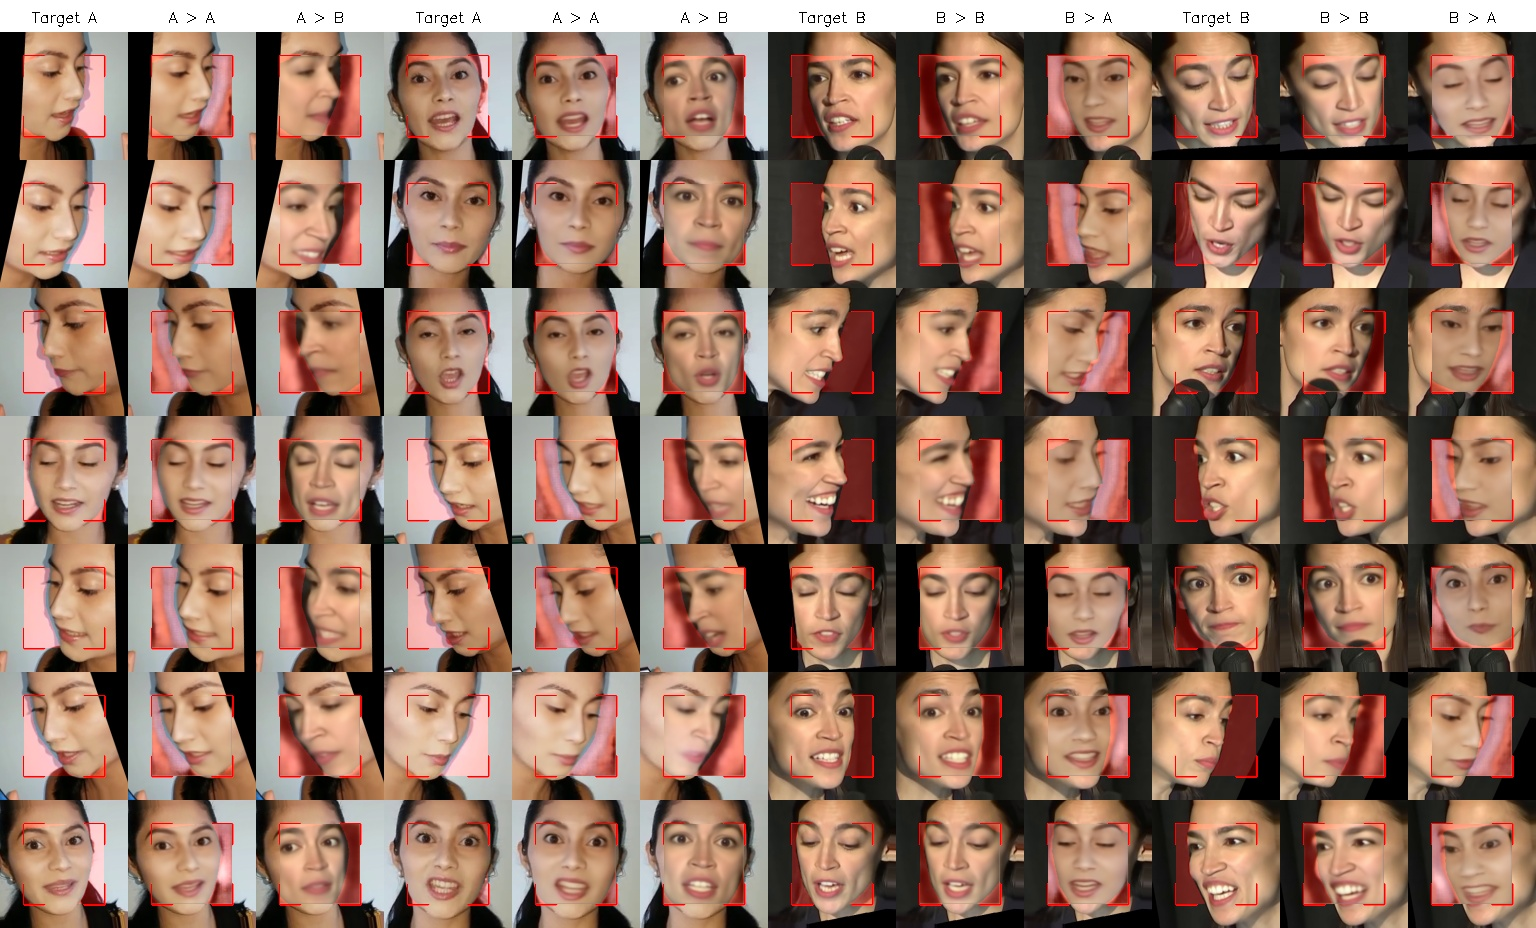

Created display.
05/08/2019 13:07:58 INFO     Log level set to: INFO
Using TensorFlow backend.
05/08/2019 13:07:59 INFO     Model A Directory: /content/face1
05/08/2019 13:07:59 INFO     Model B Directory: /content/face2
05/08/2019 13:07:59 INFO     Training data directory: /content/Drive/models
05/08/2019 13:07:59 INFO     ===============================================
05/08/2019 13:07:59 INFO     - Starting                                    -
05/08/2019 13:07:59 INFO     - Press 'ENTER' to save and quit              -
05/08/2019 13:07:59 INFO     - Press 'S' to save model weights immediately -
05/08/2019 13:07:59 INFO     ===============================================
05/08/2019 13:08:00 INFO     Loading data, this may take a while...
05/08/2019 13:08:00 INFO     Loading Model from Realface plugin...
05/08/2019 13:08:01 INFO     Using configuration saved in state file
05/08/2019 13:08:01 WARNING  From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_librar


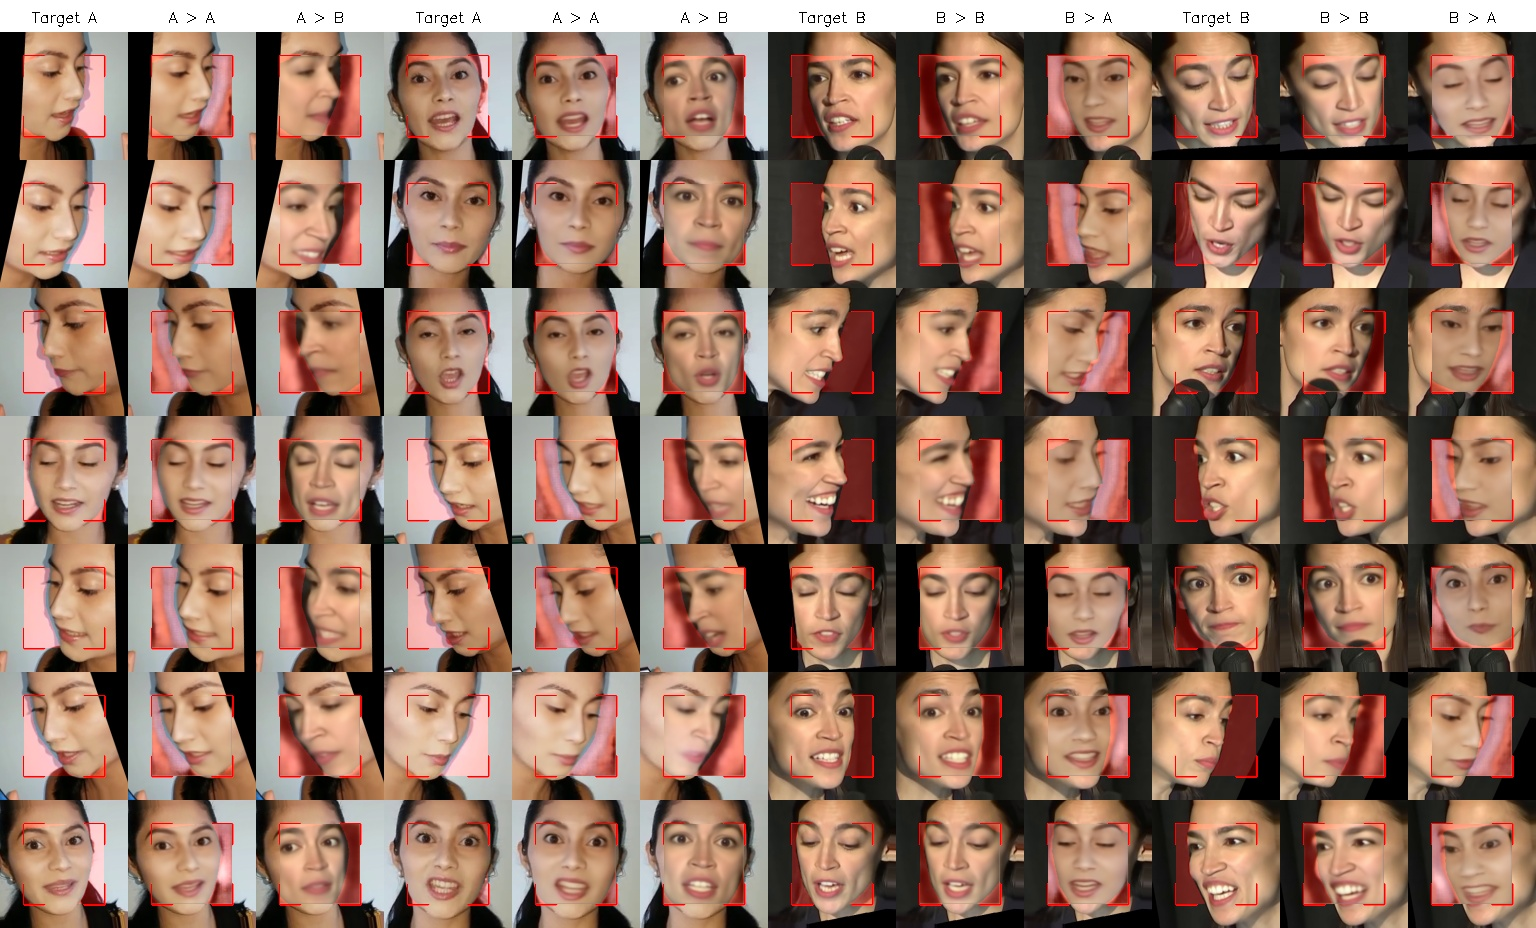

Updating display.



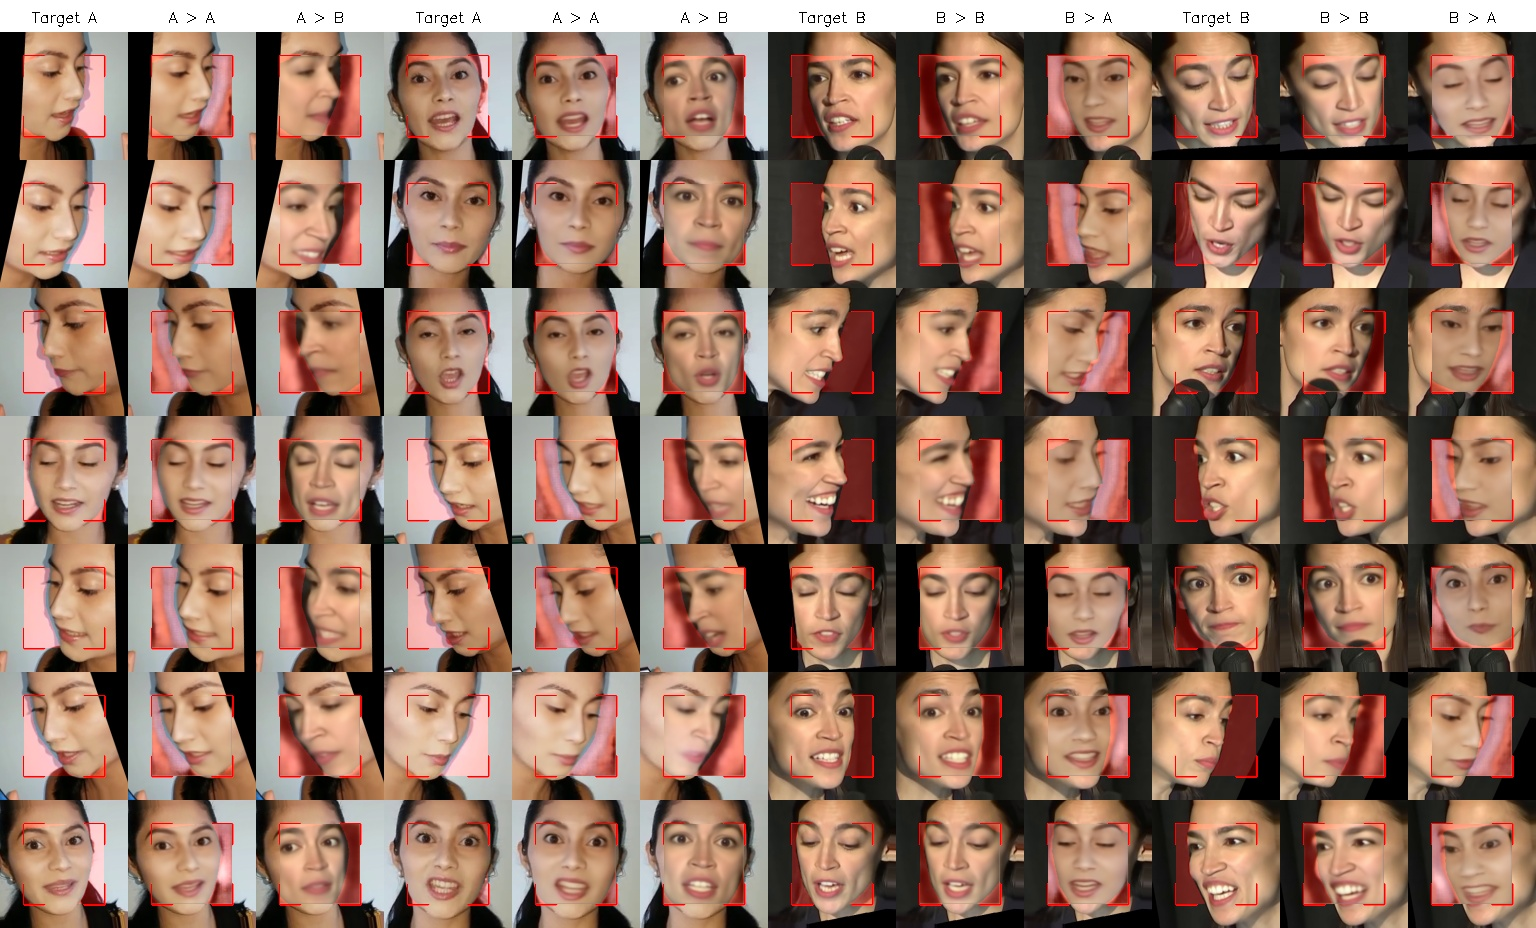

Updating display.



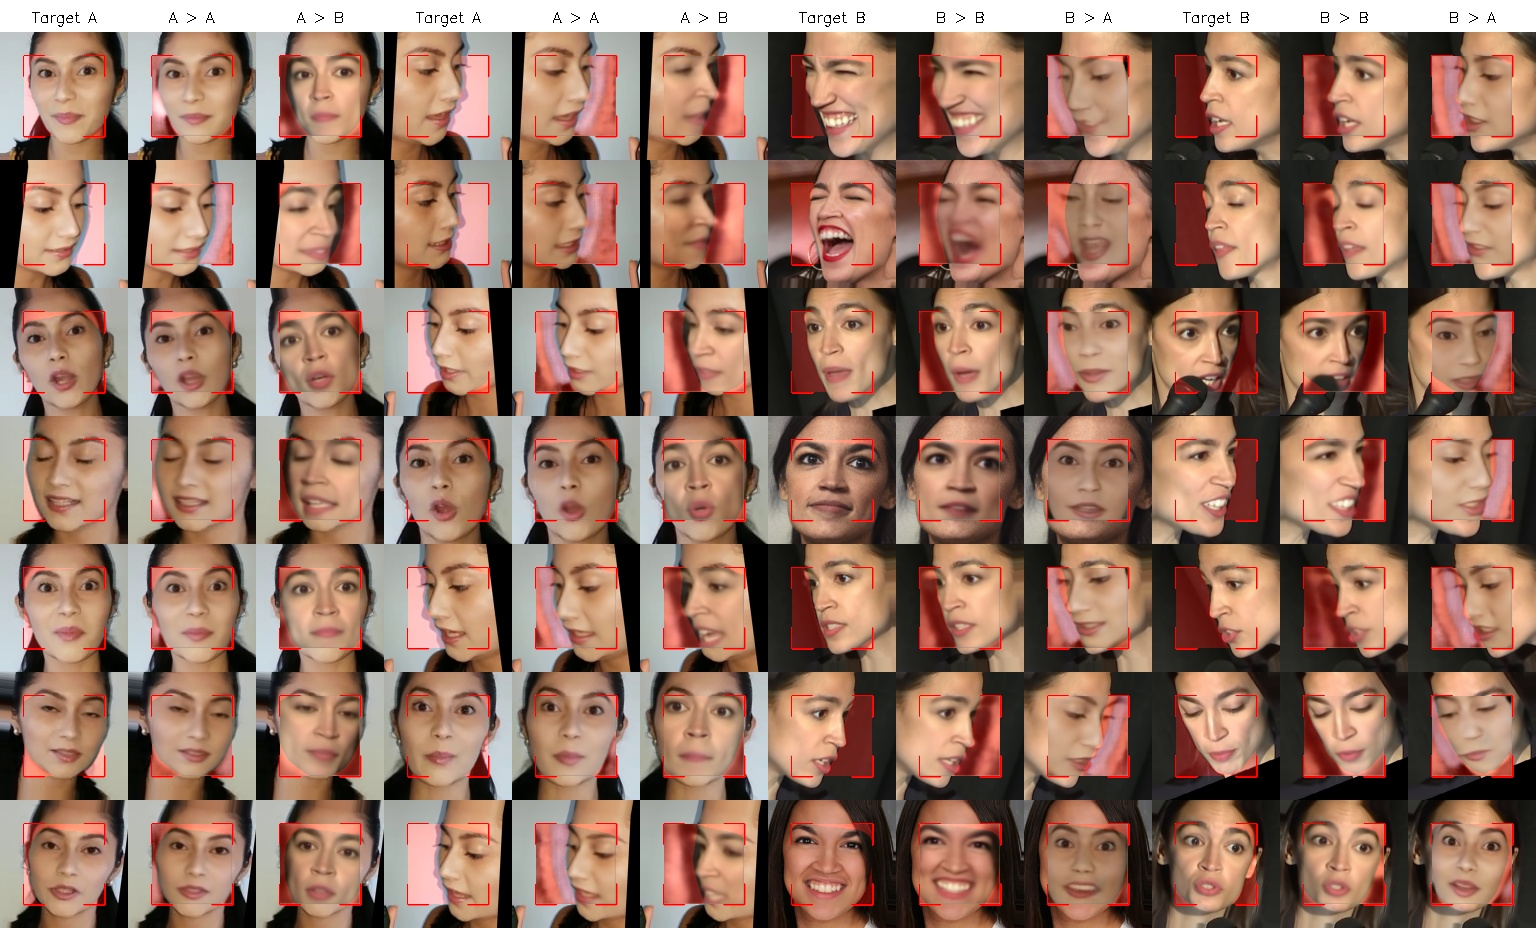

Updating display.
Updating display.


05/08/2019 13:14:22 INFO     saved models
Updating display.
Updating display.[13:17:35] [#25295] total_loss_A: 0.01158, loss_A: 0.00614, mask_loss_A: 0.00544, total_loss_B: 0.01685, loss_B: 0.00959, mask_loss_B: 0.00726
Updating display.
Updating display.


05/08/2019 13:19:37 INFO     saved models
Updating display.
Updating display.
Updating display.
Updating display.


05/08/2019 13:24:49 INFO     saved models
Updating display.
Updating display.
Updating display.
Updating display.


05/08/2019 13:30:00 INFO     saved models
Updating display.
Updating display.
Updating display.
Updating display.


05/08/2019 13:35:09 INFO     saved models
Updating display.
Updating display.
Updating display.
Updating display.


05/08/2019 13:40:19 INFO     saved models
Updating display.
Updating display.
Updating display.
Updating display.
Updating display.


05/08/2019 13:45:32 INFO     saved models
Updating display.
Updating display.
Updating display.
Updating d

In [0]:
!echo "Preview image size is reduced 3 times right click and save the image to view it in full size"

prev_img = PreviewImg()
thread = Thread(target=prev_img.task)
thread.start()

!python3 faceswap/faceswap.py train -A 'face1' -B 'face2' -ala 'Drive/bermi_video2_alignments.json' -alb 'Drive/cortez_alignments.json' -m 'Drive/models' -t realface -wl -bs 16 -s 330 -w -nl

In [26]:
!ls Drive

bermi_extract
bermi_extract_fixed
bermi_video2_alignments_20190507_231011.json
bermi_video2_alignments.json
bermi_video2.mp4
cortez
cortez_alignments_20190508_025159.json
cortez_alignments.json
cortez_alignments_premerge.json
cortez_extract
cortez_gsearch
cortez_gsearch_alignments_20190508_124323.json
cortez_gsearch_alignments.json
cortez_gsearch_extract
cortez_gsearch_extract_fixed
deepfakes
models


In [0]:
# uncomment if you have local models or files/commented are examples
# first line display contents of the folder models orther lines are for downloads

#!ls models
#files.download('models/decoder_A.h5')
#files.download('models/decoder_B.h5')
#files.download('models/encoder.h5')
#files.download('models/decoder_A.h5.bk')
#files.download('models/decoder_B.h5.bk')
#files.download('models/encoder.h5.bk')

Updating display.



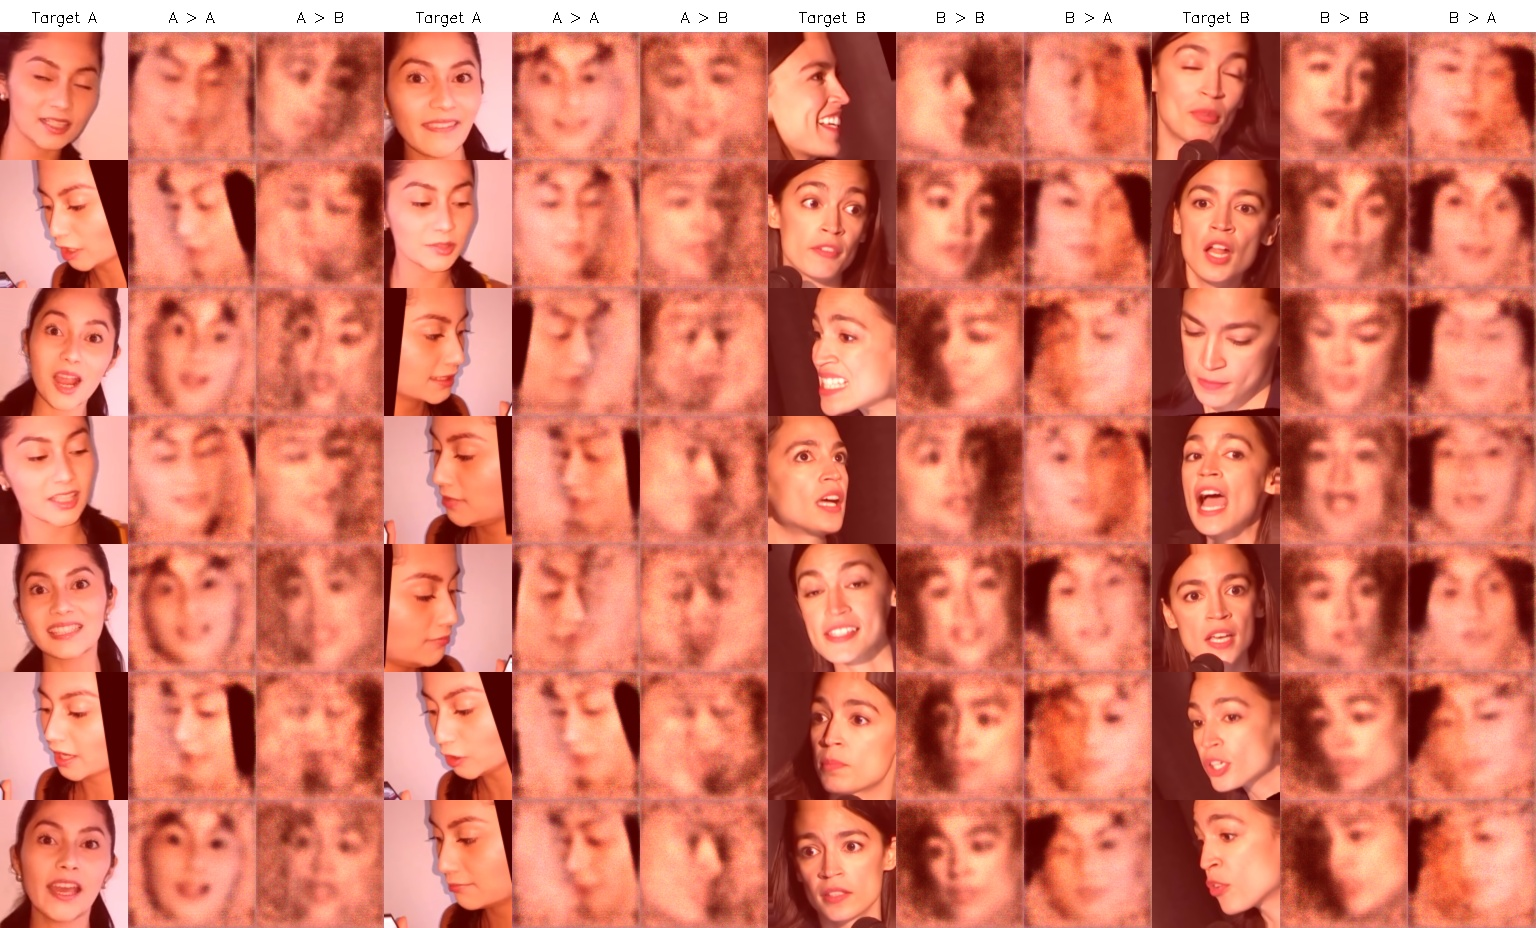

[global]
# OPTIONS THAT APPLY TO ALL MODELS
# NB: UNLESS SPECIFICALLY STATED, VALUES CHANGED HERE WILL ONLY TAKE EFFECT WHEN CREATING A NEW MODEL.

# Use ICNR Kernel Initializer for upscaling.
# This can help reduce the 'checkerboard effect' when upscaling the image.
# Choose from: True, False
# [Default: False]
icnr_init = False

# Use subpixel upscaling rather than pixel shuffler.
# Might increase speed at cost of VRAM
# Choose from: True, False
# [Default: False]
subpixel_upscaling = False

# Use reflect padding rather than zero padding. Only enable this option if the model you are training has a distinct line appearing around the edge of the swap area.
# Choose from: True, False
# [Default: False]
reflect_padding = False

# Use DSSIM for Loss rather than Mean Absolute Error
# May increase overall quality.
# Choose from: True, False
# [Default: True]
dssim_loss = True

# If using a mask, This penalizes the loss for the masked area, to give higher priority to the face area. 
# Should

In [41]:
# Shows traning config file
# Paste to cell under and run to reset the config
!cat faceswap/config/train.ini

In [0]:
# Run to update the model config file

config = """
[global]
# OPTIONS THAT APPLY TO ALL MODELS

# Use ICNR Kernel Initializer for upscaling.
# This can help reduce the 'checkerboard effect' when upscaling the image.
# Choose from: True, False
# [Default: False]
icnr_init = False

# Use subpixel upscaling rather than pixel shuffler.
# Might increase speed at cost of VRAM
# Choose from: True, False
# [Default: False]
subpixel_upscaling = False

# Use reflect padding rather than zero padding.
# Choose from: True, False
# [Default: False]
reflect_padding = False

# If using a mask, Use DSSIM loss for Mask training rather than Mean Absolute Error
# May increase overall quality.
# Choose from: True, False
# [Default: True]
dssim_mask_loss = True

# If using a mask, Use Penalized loss for Mask training. Can stack with DSSIM.
# May increase overall quality.
# Choose from: True, False
# [Default: True]
penalized_mask_loss = True

[model.dfaker]
# DFAKER MODEL (ADAPTED FROM HTTPS://GITHUB.COM/DFAKER/DF)

# The mask to be used for training. Select none to not use a mask
# Choose from: ['none', 'dfaker', 'dfl_full']
# [Default: dfaker]
mask_type = dfaker

# How much of the extracted image to train on. Generally the model is optimized
# to the default value. Sensible values to use are:
# 	62.5%% spans from eyebrow to eyebrow.
# 	75.0%% spans from temple to temple.
# 	87.5%% spans from ear to ear.
# 	100.0%% is a mugshot.
# Select a decimal number between 62.5 and 100.0
# [Default: 100.0]
coverage = 100.0

[model.dfl_h128]
# DFL H128 MODEL (ADAPTED FROM HTTPS://GITHUB.COM/IPEROV/DEEPFACELAB)

# Lower memory mode. Set to 'True' if having issues with VRAM useage.
# NB: Models with a changed lowmem mode are not compatible with each other.
# Choose from: True, False
# [Default: False]
lowmem = False

# The mask to be used for training. Select none to not use a mask
# Choose from: ['none', 'dfaker', 'dfl_full']
# [Default: dfl_full]
mask_type = dfl_full

# How much of the extracted image to train on. Generally the model is optimized
# to the default value. Sensible values to use are:
# 	62.5%% spans from eyebrow to eyebrow.
# 	75.0%% spans from temple to temple.
# 	87.5%% spans from ear to ear.
# 	100.0%% is a mugshot.
# Select a decimal number between 62.5 and 100.0
# [Default: 62.5]
coverage = 62.5

[model.iae]
# INTERMEDIATE AUTO ENCODER. BASED ON ORIGINAL MODEL, USES INTERMEDIATE LAYERS TO TRY TO BETTER GET DETAILS

# Use DSSIM for Loss rather than Mean Absolute Error
# May increase overall quality.
# Choose from: True, False
# [Default: False]
dssim_loss = False

# The mask to be used for training. Select none to not use a mask
# Choose from: ['none', 'dfaker', 'dfl_full']
# [Default: none]
mask_type = none

# How much of the extracted image to train on. Generally the model is optimized
# to the default value. Sensible values to use are:
# 	62.5%% spans from eyebrow to eyebrow.
# 	75.0%% spans from temple to temple.
# 	87.5%% spans from ear to ear.
# 	100.0%% is a mugshot.
# Select a decimal number between 62.5 and 100.0
# [Default: 62.5]
coverage = 62.5

[model.original]
# ORIGINAL FACESWAP MODEL

# Lower memory mode. Set to 'True' if having issues with VRAM useage.
# NB: Models with a changed lowmem mode are not compatible with each other.
# Choose from: True, False
# [Default: False]
lowmem = False

# Use DSSIM for Loss rather than Mean Absolute Error
# May increase overall quality.
# Choose from: True, False
# [Default: False]
dssim_loss = False

# The mask to be used for training. Select none to not use a mask
# Choose from: ['none', 'dfaker', 'dfl_full']
# [Default: none]
mask_type = none

# How much of the extracted image to train on. Generally the model is optimized
# to the default value. Sensible values to use are:
# 	62.5%% spans from eyebrow to eyebrow.
# 	75.0%% spans from temple to temple.
# 	87.5%% spans from ear to ear.
# 	100.0%% is a mugshot.
# Select a decimal number between 62.5 and 100.0
# [Default: 62.5]
coverage = 62.5

[model.unbalanced]
# AN UNBALANCED MODEL WITH ADJUSTABLE INPUT SIZE OPTIONS.
# THIS IS AN UNBALANCED MODEL SO B>A SWAPS MAY NOT WORK WELL

# Lower memory mode. Set to 'True' if having issues with VRAM useage.
# NB: Models with a changed lowmem mode are not compatible with each other. NB: lowmem will override cutom nodes and complexity settings.
# Choose from: True, False
# [Default: False]
lowmem = False

# Use DSSIM for Loss rather than Mean Absolute Error
# May increase overall quality.
# Choose from: True, False
# [Default: False]
dssim_loss = False

# The mask to be used for training. Select none to not use a mask
# Choose from: ['none', 'dfaker', 'dfl_full']
# [Default: none]
mask_type = none

# Number of nodes for decoder. Don't change this unless you know what you are doing!
# Select an integer between 512 and 4096
# [Default: 1024]
nodes = 1024

# Encoder Convolution Layer Complexity. sensible ranges: 128 to 160
# Select an integer between 64 and 1024
# [Default: 128]
complexity_encoder = 128

# Decoder A Complexity.
# Select an integer between 64 and 1024
# [Default: 384]
complexity_decoder_a = 384

# Decoder B Complexity.
# Select an integer between 64 and 1024
# [Default: 512]
complexity_decoder_b = 512

# Resolution (in pixels) of the image to train on.
# BE AWARE Larger resolution will dramatically increaseVRAM requirements.
# Make sure your resolution is divisible by 64 (e.g. 64, 128, 256 etc.).
# NB: Your faceset must be at least 1.6x larger than your required input size.
#     (e.g. 160 is the maximum input size for a 256x256 faceset)
# Select an integer between 64 and 512
# [Default: 128]
input_size = 128

# How much of the extracted image to train on. Generally the model is optimized
# to the default value. Sensible values to use are:
# 	62.5%% spans from eyebrow to eyebrow.
# 	75.0%% spans from temple to temple.
# 	87.5%% spans from ear to ear.
# 	100.0%% is a mugshot.
# Select a decimal number between 62.5 and 100.0
# [Default: 62.5]
coverage = 62.5

[model.villain]
# A HIGHER RESOLUTION VERSION OF THE ORIGINAL MODEL BY VILLAINGUY.
# EXTREMELY VRAM HEAVY. FULL MODEL REQUIRES 9GB+ FOR BATCHSIZE 16

# Lower memory mode. Set to 'True' if having issues with VRAM useage.
# NB: Models with a changed lowmem mode are not compatible with each other.
# Choose from: True, False
# [Default: False]
lowmem = False

# Use DSSIM for Loss rather than Mean Absolute Error
# May increase overall quality.
# Choose from: True, False
# [Default: False]
dssim_loss = True

# The mask to be used for training. Select none to not use a mask
# Choose from: ['none', 'dfaker', 'dfl_full']
# [Default: none]
mask_type = dfaker

# How much of the extracted image to train on. Generally the model is optimized
# to the default value. Sensible values to use are:
# 	62.5%% spans from eyebrow to eyebrow.
# 	75.0%% spans from temple to temple.
# 	87.5%% spans from ear to ear.
# 	100.0%% is a mugshot.
# Select a decimal number between 62.5 and 100.0
# [Default: 62.5]
coverage = 75
"""

with open("faceswap/config/train.ini", "w") as text_file:
    text_file.write(config)

# Convert the faces using our model
-----

In [8]:
!pip install imageio_ffmpeg ffmpy face_recognition

     |████████████████████████████████| 22.2MB 40.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/16/28/57/96aff0d874198125b03f542d854e7ebdc61a56b09a4d49de6a
Successfully built ffmpy


In [0]:
!python faceswap/faceswap.py convert -i Drive/bermi_video2.mp4 -ref Drive/bermi_video2.mp4 -o Drive/deepfakes/bermi2 -m Drive/models -w ffmpeg -al Drive/bermi_video2_alignments.json -a Drive/bermi_extract_fixed